# 残差网络

In [1]:
import torch
from torch import nn
import My_utils

blk = My_utils.Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

上述结果说明一个残差块不会改变原始tensor（输入图片）的形状

In [2]:
X = torch.rand(4, 3, 6, 6)
blk = My_utils.Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

上述是将一张图片大小减半、通道数翻倍的残差块

## ResNet的构建
ResNet有五个模块，第一个模块比较特殊，因此做特别处理；第二个模块不改变图片大小；后续三个模块图片大小减半，通道数加倍数


In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(*My_utils.resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*My_utils.resnet_block(64, 128, 2))
b4 = nn.Sequential(*My_utils.resnet_block(128, 256, 2))
b5 = nn.Sequential(*My_utils.resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512,10))
# nn.AdaptiveAvgPool2d((1,1)) 池化后每个通道都是1*1的一个像素
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'shape:   ',X.shape)

Sequential shape:    torch.Size([1, 64, 56, 56])
Sequential shape:    torch.Size([1, 64, 56, 56])
Sequential shape:    torch.Size([1, 128, 28, 28])
Sequential shape:    torch.Size([1, 256, 14, 14])
Sequential shape:    torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d shape:    torch.Size([1, 512, 1, 1])
Flatten shape:    torch.Size([1, 512])
Linear shape:    torch.Size([1, 10])


loss 0.016, train acc 0.995, test acc 0.877
2460.5 examples/sec on cuda:0


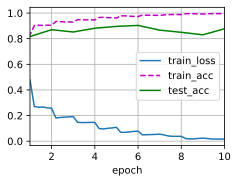

In [4]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = My_utils.load_data_from_fashion_MNIST(batch_size, resize=96)
My_utils.train_gpu(net, train_iter, test_iter, num_epochs, lr, My_utils.try_gpu())